# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


In [1]:
# Imports
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import random

import models

# Set the seed
torch.manual_seed(42)

# Check if we are running in Google Colab
RUN_COLAB = False
if RUN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dir = "/content/gdrive/MyDrive/Colab/GenAI_A3/"
else:
    dir = os.getcwd() + "/"

# Create a directory to store the results
name = 'local1'
now = datetime.datetime.now()
result_dir = dir + name + "_" + now.strftime("%Y-%m-%d_%H-%M-%S") + '/'
if (os.path.exists(result_dir)):
    raise Exception("The result directory exists. Please modify the name of the result directory.")
else:
    os.mkdir(result_dir)

# Investigate Celeba Dataset

In [2]:
def show_tensor_image(image):
    """
    Function to show a tensor image. It first apply the reverse transformation to the image and then plot it.

    Parameters
    image: torch.Tensor

    Returns
    None
    """

    # Recovere the RGB values and convert to a suitable format
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

# Define a custom dataset class that does not return the labels
class ImageFolderWithoutLabels(ImageFolder):
    """
    Custom dataset class that does not return the labels.
    """
    
    def __getitem__(self, index):
        # override the __getitem__ method to return only the image
        return super(ImageFolderWithoutLabels, self).__getitem__(index)[0]

<class 'list'>
312
<class 'list'>
Length of list train_loader:  260
Length of list val_loader:  52
Number of bathces in train_loader: 1900
Length of a batch:  32
Shape of a batch:  torch.Size([32, 3, 64, 64])


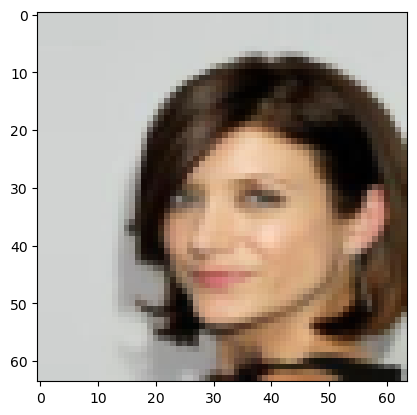

In [3]:
# DO NOT REMOVE
IMG_SIZE = 64
BATCH_SIZE = 32

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to image_size x image_size
    transforms.ToTensor(),  # Convert image to PyTorch Tensor data type
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Repeat grayscale image to 3 channels
    transforms.Lambda(lambda x: 2. * (x / x.max()) - 1.) # Normalize pixel values to [-1, 1]
])
# Load the dataset
dataset = ImageFolderWithoutLabels(root=dir + 'data/celeba', transform=transform)

# Split the dataset into train and validation and test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the dataset from images.pt
dataset = torch.load(dir + 'images.pt')
total_sample = random.sample(dataset, 260 + 52)
print(type(total_sample))
print(len(total_sample))
# Split the sampled elements into train and validation sets
train_loader = total_sample[:260]
val_loader = total_sample[260:]
print(type(dataset))
print("Length of list train_loader: ", len(train_loader))
print("Length of list val_loader: ", len(val_loader))


# Print some information about the dataloaders
print(f'Number of bathces in train_loader: {len(dataset)}')
print(f"Length of a batch: ", BATCH_SIZE)
print('Shape of a batch: ', dataset[0].shape)

# Show a sample image
show_tensor_image(next(iter(train_loader))[0])

# Time to iterate over the dataset

### Over a SINGLE batch of size 32

Dataloader: 0.16s

List Object: 0.0001089s

### If we use the whole dataset (200k images) we will have 6250 batches

Dataloader: 1000s = 16.7min

List Object: 0.6875s

These are the durations of iterating over the dataset within a SINGLE EPOCH


In [4]:
# Iterate over the whole dataset and count the time it takes
start = time.time()
for i, batch in enumerate(train_loader):
    pass
end = time.time()
print("Length of images: ", len(train_loader))
print("Shape of an image: ", batch[0].shape)
print("\nTime to iterate over the whole dataset:", end - start)

Length of images:  260
Shape of an image:  torch.Size([3, 64, 64])

Time to iterate over the whole dataset: 0.00012183189392089844


# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [5]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

### Do a forward pass

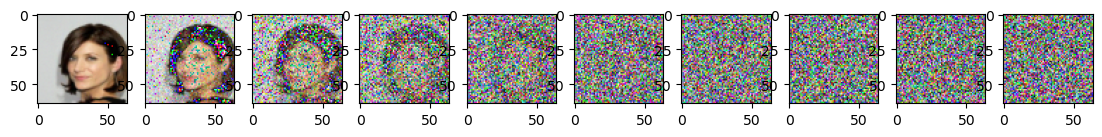

In [6]:
# Simulate forward diffusion
image = next(iter(train_loader))
# image = dataset[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed



**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [7]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    #return F.l1_loss(noise, noise_pred)
    return F.mse_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [8]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(epoch, step):
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
            
    plt.savefig(result_dir + f"image_epoch_{epoch}_step_{step}.png")
    plt.show()
    
    return img

## Initialize the model

In [9]:
# Set the device
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

# Initialize the model
model = models.SimpleUNet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Save the hyperparameters to a file
with open(result_dir + 'hyperparameters.txt', 'w') as f:
    f.write(f"IMG_SIZE: {IMG_SIZE}\n\n")
    f.write(f"BATCH_SIZE: {BATCH_SIZE}\n\n")
    f.write(f"device: {device}\n\n")
    f.write(f"T: {T}\n\n")
    f.write(f"optimizer: {optimizer}\n\n")
    f.write(f"Num params: , {sum(p.numel() for p in model.parameters())}\n\n")
    f.write(f"model: {model}\n\n")

Using device:  cpu
Num params:  15453667


## Training

In [10]:
# epochs = 1000  # Total number of epochs
# patience = 20  # Number of epochs to wait for improvement before stopping
# best_loss = float('inf')  # Initialize the best loss to a very high value
# best_epoch = 0  # Track the epoch at which the best loss was observed
# trigger_times = 0  # Count the epochs since the last improvement

# # Training loop
# train_loss = []
# val_loss = []
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     for step, batch in enumerate(train_loader):
      
#       # get the current batch size
#       current_batch_size = batch.shape[0]

#       # Zero the parameter gradients
#       optimizer.zero_grad()

#       # Initialize the timestep
#       t = torch.randint(0, T, (current_batch_size,), device=device).long()

#       # Do forward pass and get the loss
#       loss = get_loss(model, batch, t)

#       # Backward pass
#       loss.backward()
#       optimizer.step()

#       # Accumulate the loss
#       running_loss += loss.item()

#       # best model saving
#       if step % 900 == 0:

#         # Print loss
#         print(f"Epoch {epoch} | Loss: {loss.item()}")

#         # Plot the denoising process
#         sample_plot_image(epoch, step)

    
#     # Validation Loop
#     model.eval()
#     val_running_loss = 0.0
#     for step, batch in enumerate(val_loader):
#         current_batch_size = batch.shape[0]
#         t = torch.randint(0, T, (current_batch_size,), device=device).long()
#         loss = get_loss(model, batch, t)
#         val_running_loss += loss.item()

#     # Store the loss for the epoch
#     train_loss.append(running_loss/len(train_loader))
#     val_loss.append(val_running_loss/len(val_loader))
#     # Save the model if this epoch has the best loss so far

#     epoch_loss =running_loss/len(train_loader)

    
#     if epoch_loss < best_loss:
#         best_loss = epoch_loss
#         best_epoch = epoch
#         torch.save(model.state_dict(), f"{result_dir}/best_model.pth")
#         print(f"New best model saved at epoch {epoch} with loss {best_loss}")
#         trigger_times = 0  # Reset the early stopping trigger
#     else:
#         trigger_times += 1

#     # Early stopping if no improvement in the past 'patience' epochs
#     if trigger_times >= patience:
#         print(f"No improvement in loss for {patience} epochs. Stopping training.")
#         break
#     # Print the loss vs epoch
#     print(f"Epoch {epoch} | Loss: {train_loss[-1]} | Val Loss: {val_loss[-1]}")


In [11]:
# # Plot the loss
# plt.plot(train_loss, label="Training Loss")
# plt.plot(val_loss, label="Validatoin Loss")

# plt.title("Training Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.ylim(0, 0.21)
# plt.legend()
# plt.savefig(result_dir + "training_loss.png")
# plt.show()

# # Save the train_loss
# torch.save(train_loss, result_dir + "train_loss.pt")
# torch.save(val_loss, result_dir + "val_loss.pt")

### Create a Generated image dataset and dataloader

In [12]:
class FidDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

def gen_images(batch_size=2 , transform= None):
    # Adjusted to generate a batch of images
    img_size = IMG_SIZE
    images = torch.randn((batch_size, 3, img_size, img_size), device=device)
    
    # Create a dataset and dataloader
    gen_dataset = FidDataset(images, transform= transform)
    gen_dataloader = DataLoader(gen_dataset, batch_size=2, shuffle=False)
    
    plt.figure(figsize=(10,10))
    plt.axis('off')
    
    for batch_idx, img in enumerate(gen_dataloader):
        img = img.to(device)
        for i in range(0, T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.long)        
            img = sample_timestep(img, t)
            img = torch.clamp(img, -1.0, 1.0)
            if i == 0:  # Plot only the final timestep
                plt.subplot(1, batch_size, batch_idx+1)
                show_tensor_image(img.detach().cpu())
    
    # plt.savefig(result_dir + f"image_epoch_{epoch}_step_{step}.png")
    plt.show()

    return gen_dataset

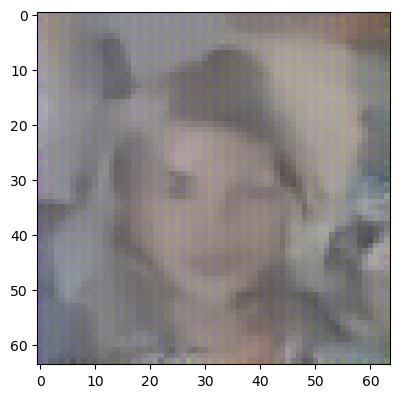

In [13]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))

# Generate images
gen_images_dataset = gen_images(batch_size=2)


In [14]:
print(type(gen_images_dataset))
print("Length of gen_images_dataset: ", len(gen_images_dataset))
print("Shape of an image: ", gen_images_dataset[0].shape)
print("image type: ", type(gen_images_dataset[0]))

<class '__main__.FidDataset'>
Length of gen_images_dataset:  2
Shape of an image:  torch.Size([3, 64, 64])
image type:  <class 'torch.Tensor'>


In [15]:
# Transform the images

# Define a transformation to resize images and convert them to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert images to PIL format
    transforms.Resize((299, 299)),  # Resize images to 299x299
    transforms.ToTensor(),  # Convert images to tensor
])

# Apply the transformation to the test images
test_transformed_dataset = FidDataset(test_dataset, transform=transform) 
test_transformed_dataloader = DataLoader(test_transformed_dataset, batch_size=2)

# Apply the transformation to the Generated images
gen_transformed_dataset = FidDataset(gen_images_dataset, transform=transform)
gen_transformed_dataloader = DataLoader(gen_transformed_dataset, batch_size= 2)

In [16]:
from torchvision.models import inception_v3
from scipy import linalg


def get_inception_features(dataloader, model, device='cpu'):
    model.eval()
    features = []

    with torch.no_grad():
        for imgs in dataloader:
            imgs = imgs.to(device)
            feature = model(imgs)[0].unsqueeze(1)
            # # Use global average pooling to convert the feature map to a vector
            # feature = torch.nn.functional.adaptive_avg_pool2d(feature, (1, 1))
            features.append(feature.cpu().numpy().reshape(imgs.size(0), -1))

    features = np.concatenate(features, axis=0)
    return features

def calculate_fid(real_features, fake_features):
    # Calculate mean and covariance statistics
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    # Adding a small value to the diagonal for numerical stability
    epsilon = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * epsilon
    sigma2 += np.eye(sigma2.shape[0]) * epsilon
    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = linalg.sqrtm(sigma1.dot(sigma2), disp=False)[0]
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Load pretrained Inception model
inception_model = inception_v3(pretrained=True).to(device)
inception_model.fc = torch.nn.Identity()  # Modify the model to return features before the final FC layer

# Extract features
fake_features = get_inception_features(gen_transformed_dataloader, inception_model, device=device)
real_features = get_inception_features(test_transformed_dataloader, inception_model, device=device)

# Calculate FID
fid_score = calculate_fid(real_features, fake_features)
print(f'FID score: {fid_score}')

/home/yasi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yasi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID score: 285.9103165965456
